<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

# TS9: Filtrado No Lineal

**Alumnas:** María Victoria Poric y Agustina Rocío Paolini Rosso  
**Carrera:** Ingeniería Biomédica    
**Materia:** Análisis y Procesamiento de Señales    
**Fecha:** Noviembre 2025 

## Consigna
En esta tarea semanal se analizarán técnicas no lineales de estimación/sustracción de la señal de movimiento de base $b(n)$.

La señal filtrada se estima como:

$$
\hat{x} = s - \hat{b}
$$

donde $s$ es la señal de ECG registrada con interferencias y $\hat{x}$ la estimación del ECG sin interferencias.

Se pide implementar las siguientes estimaciones de $b$:

1) Filtro de Mediana: se estima $\hat{b}$ mediante:

$$
\hat{b} = \text{med}_{600}(\text{med}_{200}(s))
$$

donde $\text{med}_t(s)$ es el operador de mediana aplicado sobre una ventana de $t$ milisegundos. Es decir:

$$
\hat{b}[n] = \text{med}(m[n], m[n-1], \ldots, m[n-600 \cdot fs])
$$

con:

$$
m[n] = \text{med}(s[n], s[n-1], \ldots, s[n-200 \cdot fs])
$$

2) Interpolación mediante Splines Cúbicos: a partir de las detecciones provistas en `qrs_detections`, se puede estimar el nivel isoeléctrico (segmento PQ).  

Para cada detección $n_i$, se anticipa un tiempo $n_0$ para evitar incluir las ondas P y Q. Se generan así los puntos:

$$
S = \{ (m_i, s(m_i)) \mid i = 1, 2, \ldots, Q \}
$$

donde:

$$
m_i = n_i - n_0
$$

Luego se estima la línea de base mediante un spline cúbico:

$$
\hat{b}(n) = \text{spline}_3(S, n),\quad n = 1,\ldots,N
$$

La línea de base debe estar muestreada a la misma frecuencia que el ECG.



3) Filtro Adaptado (Matched Filter): utilice el patrón provisto en `qrs_pattern1` para implementar un filtro adaptado y diseñar un detector de latidos.

a) Explicación conceptual: explique cómo se utiliza la salida del filtro adaptado para detectar latidos, discutiendo ventajas y limitaciones.

b) Detección y Métricas: compare las detecciones obtenidas con `qrs_detections`. Calcule métricas como sensibilidad (Recall) y valor predictivo positivo (Precisión).


*Bonus*:

- Proponga alguna mejora para los estimadores de la línea de base $b$, por ejemplo mediante técnicas multirate.
- Discuta si el detector basado en filtro adaptado funcionaría con un patrón perteneciente a otro paciente o registro.


## Introducción
La señal electrocardiográfica (ECG) constituye una de las herramientas fundamentales en el análisis de la actividad eléctrica del corazón. Sin embargo, su correcta interpretación depende en gran medida de la calidad del registro. Entre las interferencias más comunes y problemáticas se encuentra el movimiento de línea de base, una oscilación de muy baja frecuencia (típicamente menor a 0.5 Hz) producida por fenómenos como la respiración, desplazamientos del electrodo y variaciones en la impedancia piel-electrodo. Aunque esta interferencia es de baja frecuencia, puede poseer una energía considerable, generando desplazamientos lentos que distorsionan la forma del ECG y dificultan tareas posteriores como la detección del complejo QRS, la medición del segmento ST o el análisis de la morfología de las ondas P y T.

Si se modela el registro como la suma de la actividad cardíaca real y el movimiento de línea de base, puede escribirse:
$$
s(n) = x(n) + b(n)
$$

donde $s(n)$ representa el ECG registrado, $x(n)$ la señal cardíaca deseada y $b(n)$ la interferencia de baja frecuencia. El objetivo consiste entonces en obtener una estimación $\hat{b}(n)$ de esta última para recuperar:
$$
\hat{x}(n) = s(n) - \hat{b}(n)
$$

A diferencia de los filtros lineales tradicionales explorados previamente en la TS8, en este trabajo se abordan métodos no lineales de estimación, capaces de ofrecer mayor robustez frente a artefactos impulsivos, componentes no estacionarios y variaciones abruptas en la línea de base. Estas técnicas permiten modelar el movimiento de forma más flexible y extraerlo sin distorsionar las características esenciales del ECG, particularmente las pendientes abruptas del complejo QRS.

En este contexto se estudian dos estrategias principales. La primera es el filtro de mediana aplicado en forma secuencial sobre ventanas equivalentes a `200 ms` y `600 ms`. Este método explota la naturaleza no lineal de la mediana para suprimir componentes de alta frecuencia sin afectar estructuras más anchas, lo que lo convierte en un estimador eficaz del desplazamiento de base. La segunda técnica se basa en interpolación mediante splines cúbicos, utilizando puntos del segmento PQ (región isoeléctrica del ciclo cardíaco) para reconstruir una versión suave de la línea de base que respete la frecuencia de muestreo original. Ambas estrategias apuntan a preservar la integridad del complejo QRS y de las ondas más rápidas, evitando la distorsión asociada a filtros lineales agresivos.

Finalmente, se incorpora el estudio del filtro adaptado (matched filter), una herramienta clásica de detección óptima en presencia de ruido blanco. Mediante la correlación del ECG con un patrón QRS representativo, este filtro realza la ocurrencia de latidos y permite evaluar métricas de desempeño como sensibilidad y valor predictivo positivo. Su análisis permite además reflexionar sobre la dependencia del detector respecto del patrón utilizado y su capacidad de generalización entre distintos pacientes.

En conjunto, estas técnicas permiten comprender mejor las fortalezas y limitaciones de los métodos no lineales aplicados a la corrección de la línea de base y la detección de latidos, aspectos esenciales para el procesamiento robusto de señales biomédicas en contextos reales.

## Análisis y desarrollo
En primer lugar, se inició mediante la estimación de la línea de base. Para ello, se elaboró un código que comienza con la carga del archivo `ECG_TP4.mat` que contiene la señal de ECG, las detecciones QRS provistas y un patrón típico del complejo QRS. Se fijó la frecuencia de muestreo en `fs = 1000 Hz`, lo cual resulta fundamental ya que todas las ventanas temporales se traducen directamente en tamaños de kernel para los distintos métodos de estimación. 

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy.interpolate import CubicSpline
import scipy.io as sio

# ============================================================
#  CONFIGURACIÓN INICIAL
fs = 1000  # Hz

#  LECTURA DE ECG
mat_struct = sio.loadmat("./ECG_TP4.mat")
ecg_one_lead = mat_struct["ecg_lead"].flatten()
qrs_det = mat_struct["qrs_detections"].flatten()
cant_muestras = len(ecg_one_lead)

El primer método implementado es la sustracción de la línea de base utilizando dos filtros de mediana aplicados en cascada. El procedimiento sigue exactamente la consigna:
$$
\hat{b} = \text{med}_{600}(\text{med}_{200}(s))
$$
Dado que el operador de mediana requiere una ventana impar, las ventanas de `200 ms` y `600 ms` se convierten en `201` y `601` muestras.  

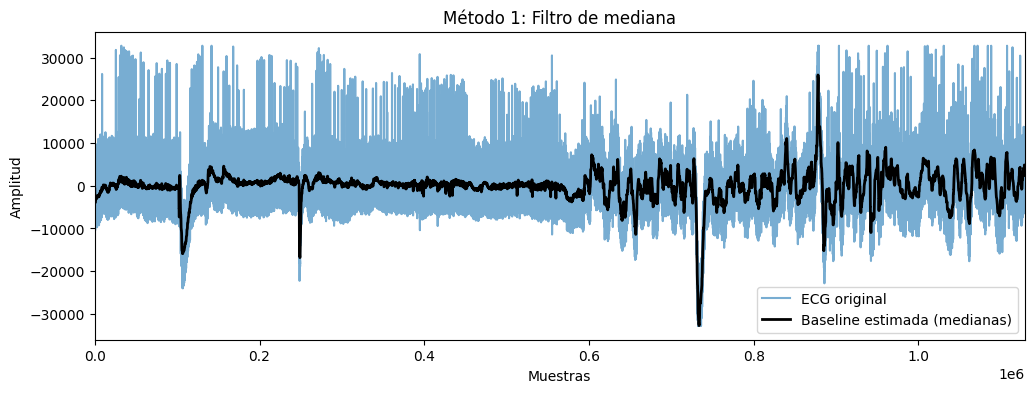

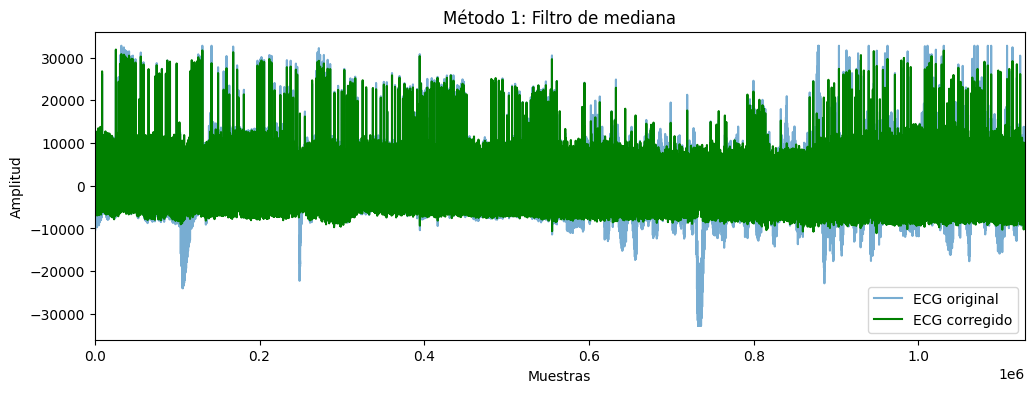

In [23]:
#  1) FILTRO DE MEDIANA

kernel_med1 = 201 
kernel_med2 = 601  

# Aplicamos el filtro de mediana de 200 ms
med_200 = sig.medfilt(ecg_one_lead, kernel_size=kernel_med1)

# Luego el filtro de 600 ms sobre la salida anterior
baseline_med = sig.medfilt(med_200, kernel_size=kernel_med2)

# ECG filtrado
ecg_med_corr = ecg_one_lead - baseline_med

plt.figure(figsize=(12,4))
plt.plot(ecg_one_lead, label="ECG original", alpha=0.6)
plt.plot(baseline_med, 'k', linewidth=2, label="Baseline estimada (medianas)")
plt.ylabel("Amplitud")
plt.xlabel("Muestras")
plt.xlim(0, len(ecg_one_lead)-1)
plt.legend()
plt.title("Método 1: Filtro de mediana")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(ecg_one_lead, label="ECG original", alpha=0.6)
plt.plot(ecg_med_corr, 'g', label="ECG corregido")
plt.ylabel("Amplitud")
plt.xlabel("Muestras")
plt.xlim(0, len(ecg_one_lead)-1)
plt.legend()
plt.title("Método 1: Filtro de mediana")
plt.show()

El primer gráfico muestra la señal de ECG original junto con la línea de base estimada mediante el método de doble filtrado por medianas. Allí puede observarse que la señal cruda no sólo contiene la actividad eléctrica cardíaca, sino también una interferencia de muy baja frecuencia que produce un desplazamiento lento del nivel basal. Este movimiento de línea de base, típico en registros reales, se debe a fenómenos como la respiración, variaciones en el contacto electrodo-piel o movimientos del paciente. Al superponerse a la señal cardíaca, esta oscilación altera la referencia isoeléctrica y puede afectar la interpretación clínica, ya que modifica artificialmente la amplitud aparente de las ondas P, QRS y T.

El doble filtrado de mediana permite estimar esta componente de baja frecuencia sin afectar significativamente la morfología del ECG. El primer filtro (200 ms) elimina picos estrechos asociados al complejo QRS, y el segundo (600 ms) suaviza aún más la señal obtenida, resultando en una estimación sólida del movimiento de línea de base. Esta curva estimada aparece en el gráfico como una traza suave que sigue las oscilaciones lentas de la señal original.

En el segundo gráfico se observa el contraste entre el ECG original y el ECG corregido tras sustraer la línea de base estimada. Debido a la extensión total del registro (cientos de miles de muestras), las variaciones rápidas quedan visualmente comprimidas, pero aun así puede apreciarse que la señal corregida se mantiene centrada en torno a un nivel constante, sin las oscilaciones lentas que dominaban la señal original. Esto indica que la corrección actúa como un filtro pasa-altos efectivo, eliminando la interferencia de baja frecuencia sin introducir distorsiones importantes.

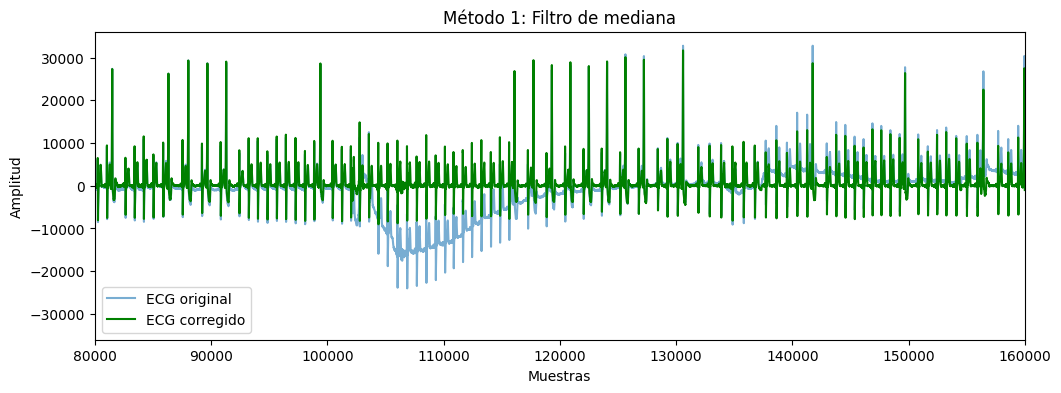

In [24]:
plt.figure(figsize=(12,4))
plt.plot(ecg_one_lead, label="ECG original", alpha=0.6)
plt.plot(ecg_med_corr, 'g', label="ECG corregido")
plt.ylabel("Amplitud")
plt.xlabel("Muestras")
plt.xlim(80000, 160000)
plt.legend()
plt.title("Método 1: Filtro de mediana")
plt.show()

Para analizar con mayor detalle el efecto del filtrado, este tercer gráfico muestra únicamente un segmento de interés de la señal (de 80000 a 160000 muestras). En esta escala reducida, la diferencia se vuelve evidente: la señal original presenta un nivel basal que varía suavemente a lo largo del tiempo, mientras que la señal corregida exhibe una línea base estable y prácticamente constante. Esta estabilización permite visualizar con mayor claridad la morfología de las ondas P, QRS y T, preservando su forma pero eliminando los desplazamientos lentos que dificultaban su identificación. Los gráficos confirman que el método de mediana logró extraer correctamente la interferencia de baja frecuencia, mejorando tanto la calidad visual de la señal como su utilidad para etapas posteriores de análisis y detección automática.

Seguidamente, el segundo método utiliza una técnica no lineal basada en la interpolación de splines cúbicos. La idea es explotar el intervalo isoeléctrico del ECG, específicamente el segmento PQ, donde la actividad eléctrica es mínima y se puede estimar la interferencia de baja frecuencia.

Para cada latido detectado en `qrs_detections`, se elige un punto $m_i = n_i - n_0$ anticipando `60 ms` respecto del QRS, evitando así la onda P y el inicio de Q. Los valores correspondientes:
$$
S = {(m_i, s(m_i))}
$$
se usan como nodos para construir un spline cúbico suave que modela la línea de base. 

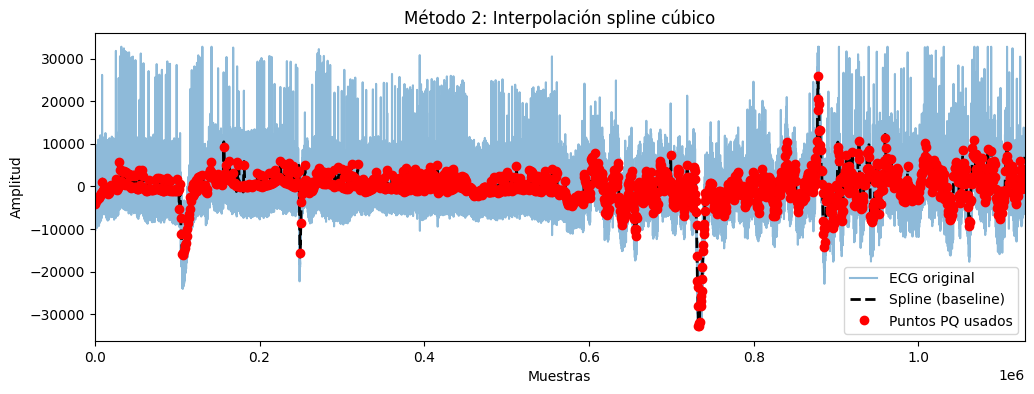

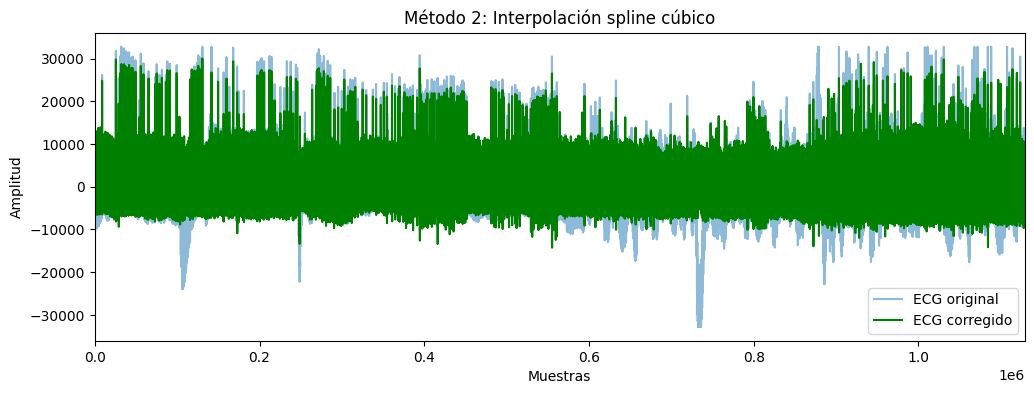

In [25]:
#  2) INTERPOLACIÓN SPLINE CÚBICO

# Aprox. 60 ms antes del QRS
n0 = 60  
mi = qrs_det - n0
mi = mi.astype(int)

mi = mi[(mi > 0) & (mi < len(ecg_one_lead))]

valores_ecg = ecg_one_lead[mi]

# Construcción del spline cúbico
spl = CubicSpline(mi, valores_ecg)

# Evaluación sobre TODA la señal
x_full = np.arange(len(ecg_one_lead))
baseline_spline = spl(x_full)

ecg_spline_corr = ecg_one_lead - baseline_spline

plt.figure(figsize=(12,4))
plt.plot(ecg_one_lead, label="ECG original", alpha=0.5)
plt.plot(baseline_spline, 'k--', linewidth=2, label="Spline (baseline)")
plt.plot(mi, valores_ecg, 'ro', label="Puntos PQ usados")
plt.ylabel("Amplitud")
plt.xlabel("Muestras")
plt.xlim(0, len(ecg_one_lead)-1)
plt.legend()
plt.title("Método 2: Interpolación spline cúbico")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(ecg_one_lead, label="ECG original", alpha=0.5)
plt.plot(ecg_spline_corr, 'g', label="ECG corregido")
plt.ylabel("Amplitud")
plt.xlabel("Muestras")
plt.xlim(0, len(ecg_one_lead)-1)
plt.legend()
plt.title("Método 2: Interpolación spline cúbico")
plt.show()

El primer gráfico correspondiente al método de spline cúbico muestra la señal de ECG original junto con la línea de base estimada a partir de la interpolación sobre puntos isoeléctricos seleccionados en el segmento PQ. Estos puntos se obtienen desplazando una cantidad fija de muestras hacia atrás desde cada detección del QRS, de modo de ubicarse en una región donde la actividad eléctrica cardíaca es mínima.

Este procedimiento permite muestrear la interferencia de baja frecuencia de manera precisa, ya que el segmento PQ representa un instante en el que el miocardio se encuentra eléctricamente estable. Los valores extraídos de estos puntos sirven como anclas o nodos para construir la función spline cúbica, que genera una curva suave y continua, capaz de aproximar la variación lenta del nivel basal a lo largo de todo el registro.

En el segundo gráfico se observa la comparación entre el ECG original y la señal corregida, obtenida al restar la línea de base generada por el spline. Debido a la gran duración del registro, la visualización completa comprime la señal, pero aun así se aprecia que la componente de muy baja frecuencia desaparece, produciendo una señal corregida más centrada y estable. A diferencia del filtro de mediana, que utiliza ventanas locales, el spline cúbico construye una estimación global de la línea de base basada en la información estructuralmente relevante del ECG, lo que puede producir una transición más suave y fisiológicamente plausible entre diferentes segmentos. 

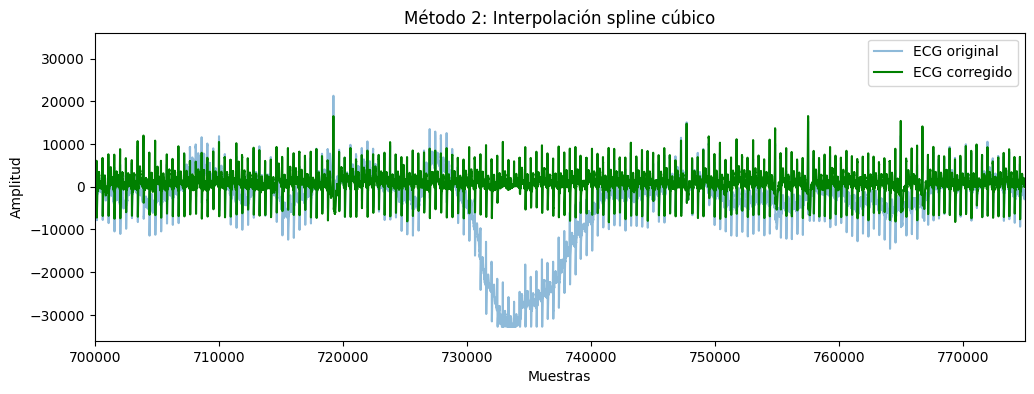

In [26]:
plt.figure(figsize=(12,4))
plt.plot(ecg_one_lead, label="ECG original", alpha=0.5)
plt.plot(ecg_spline_corr, 'g', label="ECG corregido")
plt.ylabel("Amplitud")
plt.xlabel("Muestras")
plt.xlim(700000, 775000)
plt.legend()
plt.title("Método 2: Interpolación spline cúbico")
plt.show()

En este tercer gráfico se analiza un tramo acotado del registro (de 700000 a 775000 muestras), donde la diferencia entre la señal original y la señal corregida se vuelve más evidente. El ECG original muestra variaciones amplias y lentas asociadas al movimiento de línea de base, mientras que la señal corregida mantiene una línea basal prácticamente constante. Esto facilita el análisis morfológico de las ondas del ECG, ya que las variaciones lentas ya no interfieren con la identificación precisa de las ondas P, QRS y T. Asimismo, la corrección mediante spline evita la atenuación de componentes rápidas, preservando la forma de los complejos QRS sin introducir distorsión.

Finalmente, se implementa un filtro adaptado (matched filter) para detectar señales conocidas dentro de un registro. En este caso, se emplea el patrón `qrs_pattern1`  para detectar los latidos.

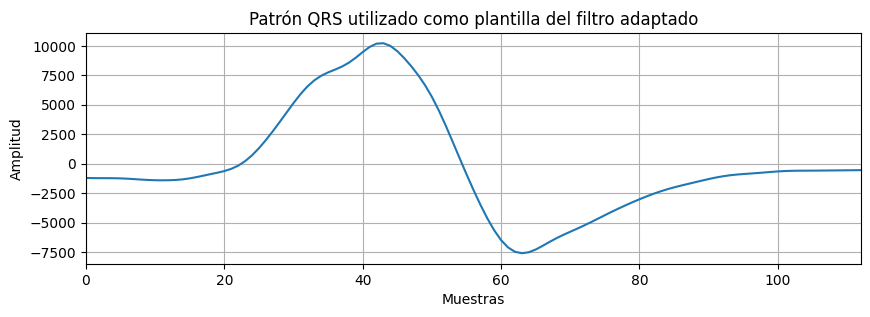

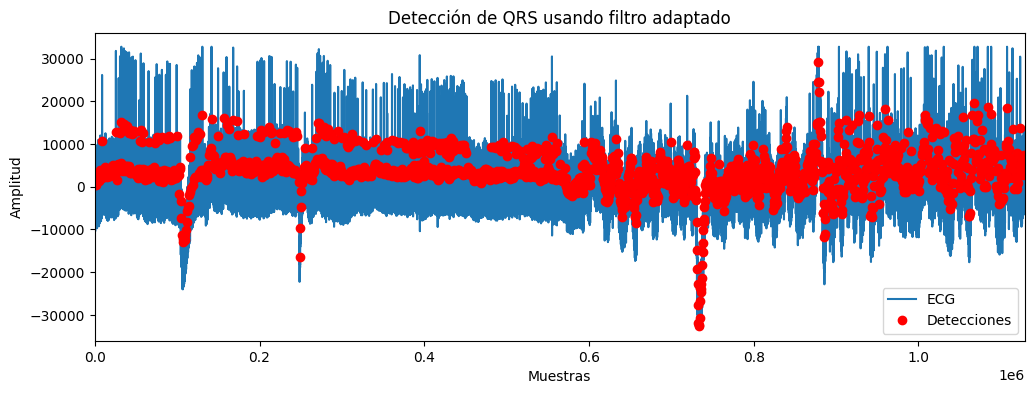

In [27]:
# 3) FILTRO ADAPTADO (MATCHED FILTER)

# PATRÓN
patron = mat_struct["qrs_pattern1"].flatten()
patron = patron - np.mean(patron)

plt.figure(figsize=(10,3))
plt.plot(patron)
plt.title("Patrón QRS utilizado como plantilla del filtro adaptado")
plt.xlabel("Muestras")
plt.xlim(0, len(patron)-1)
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

# Correlación implementada como filtrado FIR
ecg_detection = sig.lfilter(patron, 1, ecg_one_lead)
ecg_det_abs = np.abs(ecg_detection)

ecg_det_norm = ecg_det_abs / np.std(ecg_det_abs)

# Corrección del retardo del FIR
delay = (len(patron) - 1) // 2


# Detección de picos
mis_qrs, _ = sig.find_peaks(ecg_det_norm, height=1.0, distance=300)
mis_qrs_corr = mis_qrs - delay
mis_qrs_corr = mis_qrs_corr[mis_qrs_corr > 0]

plt.figure(figsize=(12,4))
plt.plot(ecg_one_lead, label="ECG")
plt.plot(mis_qrs_corr, ecg_one_lead[mis_qrs_corr], 'ro', label="Detecciones")
plt.ylabel("Amplitud")
plt.xlabel("Muestras")
plt.xlim(0, len(ecg_one_lead)-1)
plt.legend()
plt.title("Detección de QRS usando filtro adaptado")
plt.show()

El filtro adaptado es una técnica clásica de detección que maximiza la relación señal-ruido cuando se conoce de antemano la forma del evento que se desea identificar. En este caso, el evento de interés es el complejo QRS del electrocardiograma, cuya morfología típica se encuentra almacenada en la plantilla `qrs_pattern1`, que puede observarse en el primer gráfico. 

Al emplear esta plantilla como impulso del filtro FIR, la salida del filtro equivale a calcular la correlación entre la señal de ECG y la forma característica del QRS. Cuando un segmento de la señal se parece fuertemente al patrón, la salida del filtro presenta un máximo pronunciado; por lo tanto, los picos positivos de la señal filtrada funcionan como indicadores directos de la presencia de un latido.

Antes de aplicar la correlación, se elimina el nivel DC del patrón para evitar que el filtro responda a componentes lentas que no son representativas del QRS. Luego, la salida del filtro se pasa a valor absoluto y se normaliza respecto de su desvío estándar, lo que estabiliza su amplitud frente a variaciones en la energía local del QRS o del ruido. 

Sobre esta señal normalizada se aplica un detector simple de picos con un umbral y una distancia mínima entre detecciones, garantizando que cada máximo significativo (correspondiente a un QRS) sea detectado al menos una vez. Una vez obtenidas las detecciones, se corrige el retardo introducido por el FIR para alinear la estimación con el instante real del complejo QRS.

Desde un punto de vista conceptual, una de las principales ventajas del filtro adaptado es que explota la forma completa del QRS y no únicamente su amplitud, por lo que es muy robusto frente al ruido blanco y frente a ciertos artefactos que no se asemejan al patrón. 

Sin embargo, presenta algunas limitaciones: su desempeño depende fuertemente de cuán representativo sea el patrón respecto de los QRS reales del registro, pues variaciones morfológicas grandes (por ejemplo, arritmias, extrasístoles o pacientes distintos) reducen la calidad de la correlación. Asimismo, la técnica no es ideal frente a ruido impulsivo o interferencias que puedan generar picos altos no relacionados con la actividad cardíaca.


=== MÉTRICAS DEL DETECTOR ===
TP = 1902, FP = 3, FN = 1
Precisión (PPV) = 0.998
Sensibilidad = 0.999
F1-score = 0.999


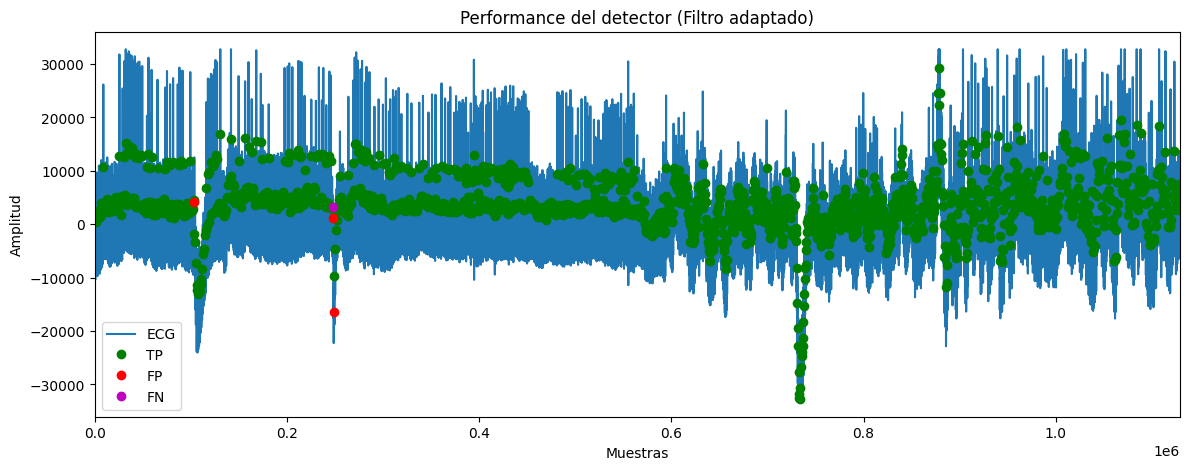

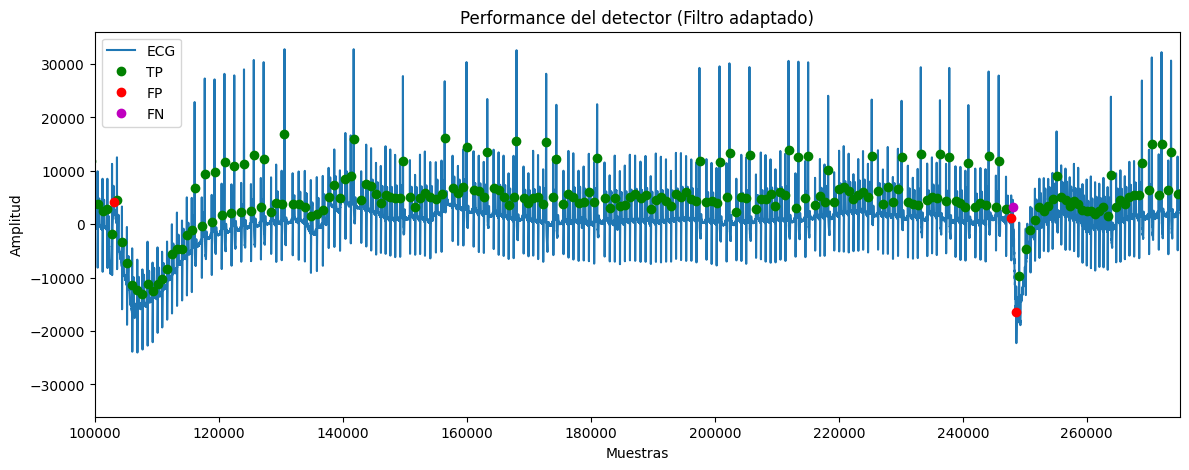

In [28]:
# 3.c) MATRIZ DE CONFUSIÓN
def matriz_confusion_qrs(mis_qrs, qrs_det, tolerancia_ms=150, fs=1000):
    mis_qrs = np.array(mis_qrs)
    qrs_det = np.array(qrs_det)

    tol = tolerancia_ms * fs / 1000

    TP = 0
    FP = 0
    FN = 0

    mis_usados = np.zeros(len(mis_qrs), dtype=bool)
    ref_usados = np.zeros(len(qrs_det), dtype=bool)

    for i, det in enumerate(mis_qrs):
        diff = np.abs(qrs_det - det)
        idx = np.argmin(diff)

        if diff[idx] <= tol and not ref_usados[idx]:
            TP += 1
            mis_usados[i] = True
            ref_usados[idx] = True

    FP = np.sum(~mis_usados)
    FN = np.sum(~ref_usados)

    return TP, FP, FN, mis_usados, ref_usados

TP, FP, FN, mis_usados, ref_usados = matriz_confusion_qrs(mis_qrs_corr, qrs_det)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("\n=== MÉTRICAS DEL DETECTOR ===")
print(f"TP = {TP}, FP = {FP}, FN = {FN}")
print(f"Precisión (PPV) = {precision:.3f}")
print(f"Sensibilidad = {recall:.3f}")
print(f"F1-score = {f1:.3f}")

# Gráfico con TP, FP, FN
tp_idx = np.where(mis_usados)[0]
fp_idx = np.where(~mis_usados)[0]
fn_idx = np.where(~ref_usados)[0]

plt.figure(figsize=(14,5))
plt.plot(ecg_one_lead, label="ECG")
plt.plot(mis_qrs_corr[tp_idx], ecg_one_lead[mis_qrs_corr[tp_idx]], 'go', label="TP")
plt.plot(mis_qrs_corr[fp_idx], ecg_one_lead[mis_qrs_corr[fp_idx]], 'ro', label="FP")
plt.plot(qrs_det[fn_idx], ecg_one_lead[qrs_det[fn_idx]], 'mo', label="FN")
plt.ylabel("Amplitud")
plt.xlabel("Muestras")
plt.xlim(0, len(ecg_one_lead)-1)
plt.legend()
plt.title("Performance del detector (Filtro adaptado)")
plt.show()

plt.figure(figsize=(14,5))
plt.plot(ecg_one_lead, label="ECG")
plt.plot(mis_qrs_corr[tp_idx], ecg_one_lead[mis_qrs_corr[tp_idx]], 'go', label="TP")
plt.plot(mis_qrs_corr[fp_idx], ecg_one_lead[mis_qrs_corr[fp_idx]], 'ro', label="FP")
plt.plot(qrs_det[fn_idx], ecg_one_lead[qrs_det[fn_idx]], 'mo', label="FN")
plt.ylabel("Amplitud")
plt.xlabel("Muestras")
plt.xlim(100000, 275000)
plt.legend()
plt.title("Performance del detector (Filtro adaptado)")
plt.show()

En cuanto a la evaluación del detector, las posiciones estimadas se compararon con las detecciones provistas en `qrs_detections` utilizando una ventana de tolerancia de `150 ms` para considerar coincidencias válidas. A partir de esta comparación se obtuvieron 1902 verdaderos positivos (TP), únicamente 3 falsos positivos (FP) y 1 falso negativo (FN). Con estos valores se calcularon las métricas clásicas de desempeño:

- Valor predictivo positivo (Precisión / PPV): 0.998
- Sensibilidad (Recall): 0.999
- F1-score: 0.999

Estos resultados muestran que el detector basado en filtro adaptado presenta un rendimiento sobresaliente para este registro específico: prácticamente todos los latidos fueron detectados y casi no se generaron falsas alarmas. Tal desempeño refleja tanto la adecuación de la plantilla utilizada como la estabilidad morfológica del registro analizado. Sin embargo, es importante destacar que esta excelente performance podría disminuir si el patrón no representa fielmente los QRS reales de otro paciente o si existieran variaciones significativas entre latidos.

## Bonus
Como mejora opcional a los estimadores de línea de base previos, se implementó un método basado en técnicas multirate. La idea principal consiste en reducir la tasa de muestreo de la señal para concentrarse únicamente en las variaciones lentas, eliminando de manera natural los componentes de alta frecuencia asociadas a las ondas P, QRS y T.

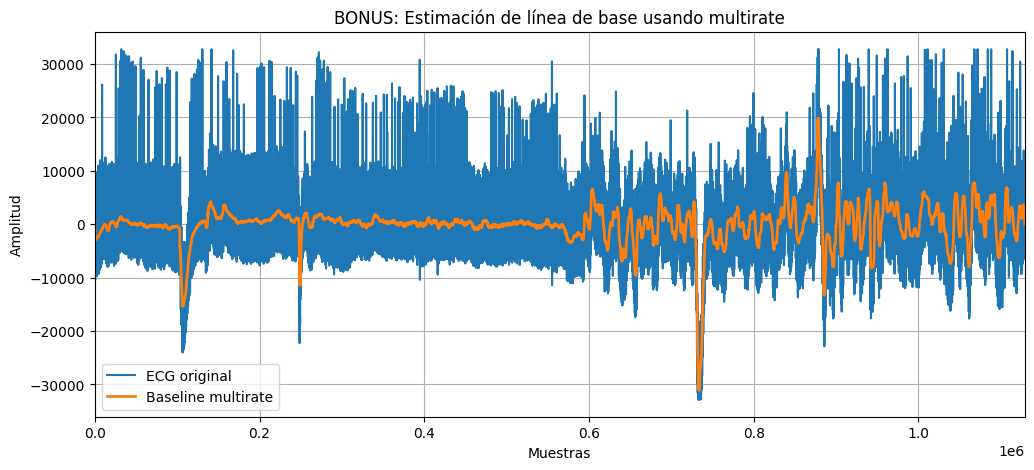

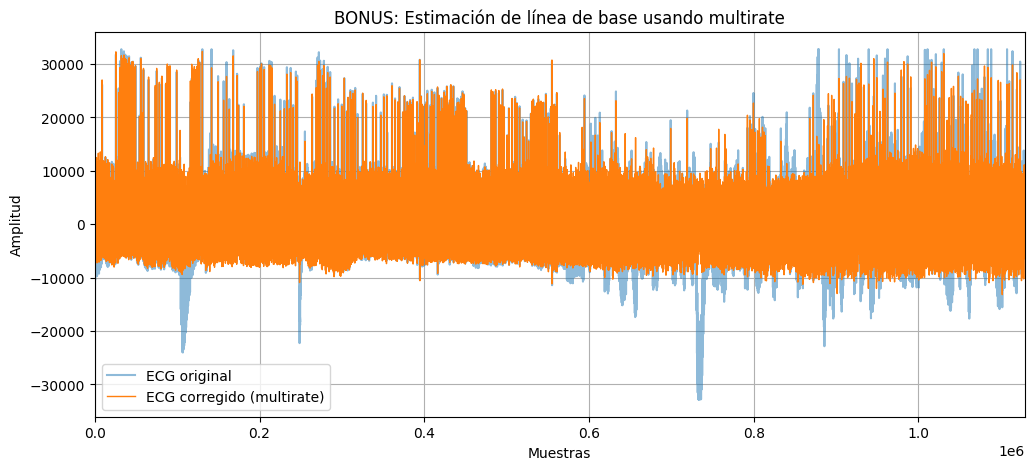

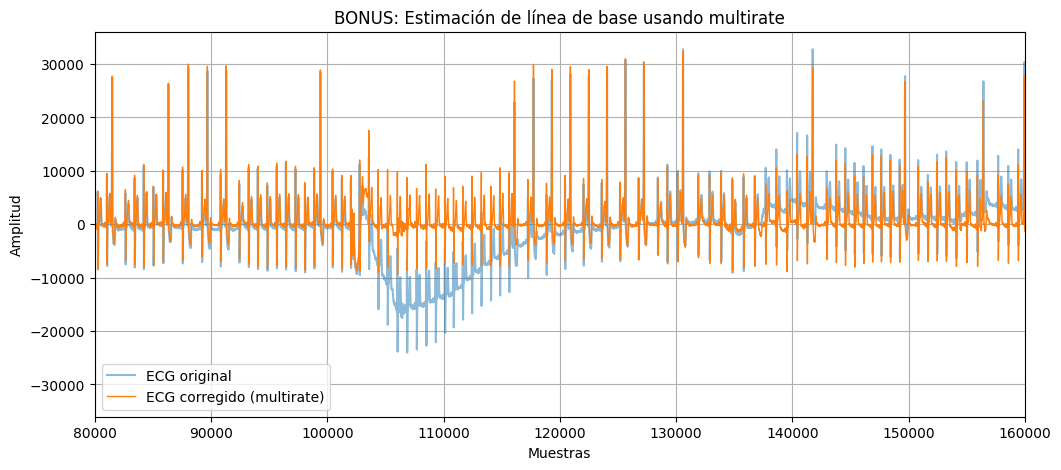

In [33]:
# %% BONUS: Baseline multirate 

# Factor de diezmado (baja frecuencia)
D = 50

# Diezmar la señal ECG
ecg_dec = ecg_one_lead[::D]
ventana = 51
ecg_dec_smooth = sig.medfilt(ecg_dec, kernel_size=ventana)

# Interpolar de nuevo a la longitud original
x_dec = np.arange(len(ecg_dec))
x_full = np.linspace(0, len(ecg_dec)-1, len(ecg_one_lead))
baseline_multirate = np.interp(x_full, x_dec, ecg_dec_smooth)

# ECG corregido usando baseline multirate
ecg_corr_multirate = ecg_one_lead - baseline_multirate

plt.figure(figsize=(12,5))
plt.plot(ecg_one_lead, label='ECG original')
plt.plot(baseline_multirate, label='Baseline multirate', linewidth=2)
plt.title('BONUS: Estimación de línea de base usando multirate')
plt.ylabel('Amplitud')
plt.xlabel('Muestras')
plt.xlim(0, len(ecg_one_lead)-1)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(ecg_one_lead, label='ECG original', alpha=0.5)
plt.plot(ecg_corr_multirate, label='ECG corregido (multirate)', linewidth=1)
plt.title('BONUS: Estimación de línea de base usando multirate')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xlim(0, len(ecg_one_lead)-1)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(ecg_one_lead, label='ECG original', alpha=0.5)
plt.plot(ecg_corr_multirate, label='ECG corregido (multirate)', linewidth=1)
plt.title('BONUS: Estimación de línea de base usando multirate')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xlim(80000, 160000)
plt.legend()
plt.grid(True)
plt.show()

Al diezmar la señal por un factor significativo (en este caso, `D = 50`), la actividad cardíaca queda muy comprimida en el dominio temporal y, por lo tanto, aparece como ruido de alta frecuencia respecto del nuevo muestreo. Sobre esta señal diezmada se aplica un suavizado mediante un filtro de mediana de gran ventana, que es computacionalmente muy barato en el dominio diezmado.

Finalmente, la señal suavizada se interpola nuevamente hasta la longitud original, obteniendo así una estimación suave, continua y de muy baja frecuencia de la línea de base $b[n]$. Esta estrategia actúa efectivamente porque combina reducción de datos, suavizado y posterior interpolación, permitiendo obtener una línea de base suave sin necesidad de filtros FIR muy largos ni costos computacionales elevados. La señal ECG corregida muestra un comportamiento estable y comparable a las correcciones obtenidas mediante filtros de mediana o spline cúbico, lo que demuestra que la técnica multirate es una alternativa válida y eficiente para la supresión del desplazamiento de línea de base.

En cuanto al detector basado en filtro adaptado (última pregunta del bonus), su funcionamiento depende críticamente de que la plantilla utilizada represente adecuadamente la morfología de los complejos QRS del registro analizado. En este trabajo se empleó el patrón `qrs_pattern1`, obtenido del propio registro del paciente; por lo tanto, la correlación resultó muy eficiente y produjo detecciones prácticamente perfectas. Sin embargo, si se utilizara un patrón perteneciente a otro paciente o incluso a otro segmento del mismo registro con morfología significativamente distinta, la salida del filtro adaptado podría degradarse notablemente. Esto ocurre porque el filtro responde con máxima energía solo cuando la forma del QRS se asemeja estrechamente al patrón. Frente a variabilidad morfológica (por ejemplo, QRS más anchos, latidos ectópicos, bloqueo de rama, artefactos o condiciones patológicas), el valor máximo de correlación disminuye, pudiendo derivar en falsos negativos. Del mismo modo, si el patrón contiene características no presentes en la señal real, el filtro podría reaccionar erróneamente ante ruidos o transitorios que coincidan parcialmente con el patrón, generando falsos positivos.

Por lo tanto, el filtro adaptado funciona de manera óptima únicamente cuando la plantilla es representativa y estable. Ante cambios de paciente o de morfología del latido, sería necesario actualizar dinámicamente el patrón o recurrir a técnicas más robustas, como clasificadores basados en aprendizaje automático o detectores que analicen múltiples características además de la forma temporal.

## Conclusiones

En este trabajo se analizaron distintos métodos no lineales para la estimación y corrección del movimiento de línea de base en registros electrocardiográficos, así como un detector de latidos basado en filtro adaptado. Los resultados obtenidos muestran que, aunque la interferencia de baja frecuencia puede alterar de manera significativa la morfología del ECG, es posible extraerla de forma eficiente sin distorsionar las componentes rápidas asociadas al complejo QRS. 

El filtrado mediante medianas en cascada demostró ser un medio robusto y efectivo para capturar la variación lenta del nivel basal. Su naturaleza no lineal permite preservar la morfología del ECG, incluso en presencia de artefactos impulsivos, obteniendo una señal final estable y clínicamente interpretable. Por otra parte, la técnica basada en splines cúbicos permitió construir una estimación suave y fisiológicamente plausible del movimiento de línea de base, aprovechando el carácter isoeléctrico del segmento PQ. Ambas estrategias ofrecieron correcciones consistentes, con diferencias principalmente en la suavidad global de la línea de base estimada. 

La incorporación del enfoque multirate evidenció que también es posible obtener un estimador adecuado de la línea de base mediante reducción y posterior interpolación, logrando resultados comparables con un costo computacional reducido. Esto constituye una alternativa atractiva para aplicaciones con restricciones de procesamiento. 

Por último, el detector QRS basado en filtro adaptado alcanzó un desempeño sobresaliente, con valores de sensibilidad, valor predictivo positivo y F1-score cercanos a la unidad. Esto confirma la eficacia de la correlación con un patrón representativo cuando la morfología del QRS es estable. Sin embargo, también se destacó su principal limitación: la dependencia directa respecto de la plantilla utilizada. En escenarios con variaabilidad morfológica significativa, la performance podría degradarse, lo que motiva la necesidad de adaptar el patrón o recurrir a métodos flexibles. 

En conjunto, los resultados muestran que los métodos no lineales constituyen herramientas poderosas para el procesamiento del ECG, capaces de suprimir interferencias sin comprometer la información clínica relevante. Además, el análisis del filtro adaptado permite comprender cuando la señal presenta variaciones fisológicas o patológicas. Estas técnicas, correctamente seleccionadas y combinadas, resultan fundamentales para mejorar la calidad del registro y la confiabilidad de los sistemas automatizados de análisis de señales biomédicas. 

## Autoevaluación del aprendizaje

En relación a este trabajo sentimos que comprendimos y aprendimos sobre las técnicas de filtración no lineal. Destacamos las ventajas y desventajas de cada método, fue de gran utilidad trabajar con ellas en clase ya que de esa forma comprendimos mejor el funcionamiento mediante la prueba y error de distintos valores y distintas técnicas para implementarlos. 

Creemos que estos distintos métodos comprenden una herramienta fundamental para el filtrado alineal y al utilizar 3 maneras distintas, contamos con distintas estrategias para resolver estos problemas, entendiendo por qué una es mejor que otra o en qué ámbito destaca una por sobre la otra.

Acudimos al Holton para un respaldo teórico de las distintas técnicas y la librería scipy. Asimismo, utilizamos ChatGPT para correciones del código. 